In [1]:
%load_ext autoreload
%autoreload 2
import sys
from pathlib import Path
path = str(Path.cwd().parent)
print(path)
sys.path.insert(1, path)

import numpy as np
import pandas as pd
import skforecast

print(skforecast.__version__)

c:\Users\jaesc2\GitHub\skforecast
0.20.0


In [2]:
# Libraries
# ==============================================================================
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from skforecast.datasets import fetch_dataset
from skforecast.stats import Arima, Sarimax
from skforecast.recursive import ForecasterStats
from skforecast.model_selection import TimeSeriesFold, backtesting_stats
from skforecast.utils import expand_index
from skforecast.plot import set_dark_theme, plot_prediction_intervals
import warnings

set_dark_theme()
warnings.filterwarnings('once')

In [3]:
# Download data
# ==============================================================================
data = fetch_dataset(name="h2o_exog")
data.index.name = 'datetime'

╭─────────────────────────────────── h2o_exog ────────────────────────────────────╮
│ Description:                                                                    │
│ Monthly expenditure ($AUD) on corticosteroid drugs that the Australian health   │
│ system had between 1991 and 2008. Two additional variables (exog_1, exog_2) are │
│ simulated.                                                                      │
│                                                                                 │
│ Source:                                                                         │
│ Hyndman R (2023). fpp3: Data for Forecasting: Principles and Practice (3rd      │
│ Edition). http://pkg.robjhyndman.com/fpp3package/,                              │
│ https://github.com/robjhyndman/fpp3package, http://OTexts.com/fpp3.             │
│                                                                                 │
│ URL:                                                                            │
│ https://raw.githubusercontent.com/skforecast/skforecast-                        │
│ datasets/main/data/h2o_exog.csv                                                 │
│                                                                                 │
│ Shape: 195 rows x 3 columns                                                     │
╰─────────────────────────────────────────────────────────────────────────────────╯

Train dates : 1992-04-01 00:00:00 --- 2005-06-01 00:00:00  (n=159)
Test dates  : 2005-07-01 00:00:00 --- 2008-06-01 00:00:00  (n=36)


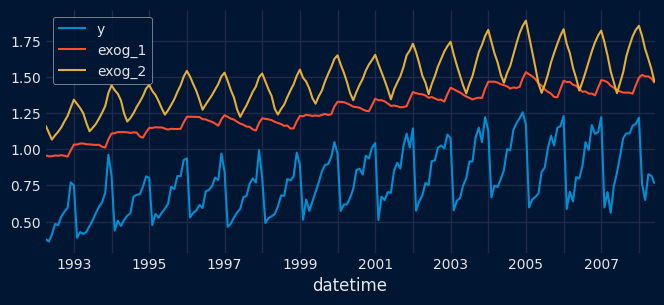

In [4]:
# Train-test dates
# ==============================================================================
end_train = '2005-06-01 23:59:59'

print(
    f"Train dates : {data.index.min()} --- {data.loc[:end_train].index.max()}  "
    f"(n={len(data.loc[:end_train])})"
)
print(
    f"Test dates  : {data.loc[end_train:].index.min()} --- {data.loc[:].index.max()}  "
    f"(n={len(data.loc[end_train:])})"
)

data_train = data.loc[:end_train]
data_test  = data.loc[end_train:]

# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3))
data.plot(ax=ax)
ax.legend();

In [5]:
model = Sarimax(order=(12, 1, 1), seasonal_order=(0, 0, 0, 0))
model.fit(y=data_train['y'])
model

c:\Users\jaesc2\Miniconda3\envs\skforecast_py13\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\jaesc2\Miniconda3\envs\skforecast_py13\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


,order,"(12, ...)"
,seasonal_order,"(0, ...)"
,trend,None
,measurement_error,False
,time_varying_regression,False
,mle_regression,True
,simple_differencing,False
,enforce_stationarity,True
,enforce_invertibility,True
,hamilton_representation,False
,concentrate_scale,False


In [6]:
# Model summary
# ==============================================================================
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  159
Model:              SARIMAX(12, 1, 1)   Log Likelihood                 234.019
Date:                Fri, 30 Jan 2026   AIC                           -440.038
Time:                        19:33:56   BIC                           -397.162
Sample:                    04-01-1992   HQIC                          -422.626
                         - 06-01-2005                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0317      0.062     -0.513      0.608      -0.153       0.089
ar.L2         -0.0656      0.053     -1.248      0.212      -0.169       0.037
ar.L3         -0.0346      0.063     -0.551      0.582      -0.158       0.089
ar.L4         -0.0760      0.058     -1.307      0.191      -0.190       0.038
ar.L5         -0.0535      0.066     -0.808      0.419      -0.183       0.076
ar.L6         -0.0368      0.068     -0.542      0.588      -0.170       0.096
ar.L7         -0.0788      0.056     -1.401      0.161      -0.189       0.031
ar.L8         -0.0374      0.054     -0.693      0.488      -0.143       0.068
ar.L9         -0.0529      0.057     -0.922      0.356      -0.165       0.060
ar.L10        -0.0571      0.054     -1.054      0.292      -0.163       0.049
ar.L11         0.0112      0.054      0.209      0.835      -0.094       0.116
ar.L12         0.8600      0.045     18.930      0.000       0.771       0.949
ma.L1         -0.6204      0.089     -6.933      0.000      -0.796      -0.445
sigma2         0.0026      0.000      9.686      0.000       0.002       0.003
===================================================================================
Ljung-Box (L1) (Q):                   0.91   Jarque-Bera (JB):                 9.88
Prob(Q):                              0.34   Prob(JB):                         0.01
Heteroskedasticity (H):               1.54   Skew:                            -0.31
Prob(H) (two-sided):                  0.12   Kurtosis:                         4.05
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [7]:
predictions = model.predict(
    steps=len(data_test), return_conf_int=True, alpha=0.05
)
predictions.head(3)

,pred,lower_bound,upper_bound
2005-07-01,0.958233,0.858469,1.057998
2005-08-01,0.957407,0.851777,1.063037
2005-09-01,1.104670,0.994800,1.214539


In [8]:
# ARIMA model with skforecast Arima classs
# ==============================================================================
model = Arima(order=(12, 1, 0), seasonal_order=(0, 0, 0), m=12)
model.fit(y=data_train['y'])
model

c:\Users\jaesc2\GitHub\skforecast\skforecast\stats\arima\_arima_base.py:2571: UserWarning: Possible convergence problem. Try to increase 'maxiter' or change the optimization method.
  warnings.warn(


,order,"(12, ...)"
,seasonal_order,"(0, ...)"
,m,12
,include_mean,True
,transform_pars,True
,method,'CSS-ML'
,n_cond,None
,SSinit,'Gardner1980'
,optim_method,'BFGS'
,optim_kwargs,{'maxiter': 1000}
,kappa,1000000.0


In [9]:
# Model summary
# ==============================================================================
model.summary()

ARIMA Model Summary
Model     : Arima(12,1,0)
Method    : ARIMA(12,1,0)(0,0,0)[12]
Converged : False

Coefficients:
------------------------------------------------------------
  ar1            :    -0.4555  (SE:      nan, t:      nan)
  ar2            :    -0.4351  (SE:      nan, t:      nan)
  ar3            :    -0.4174  (SE:      nan, t:      nan)
  ar4            :    -0.4496  (SE:      nan, t:      nan)
  ar5            :    -0.4324  (SE:      nan, t:      nan)
  ar6            :    -0.4201  (SE:      nan, t:      nan)
  ar7            :    -0.4527  (SE:      nan, t:      nan)
  ar8            :    -0.4173  (SE:      nan, t:      nan)
  ar9            :    -0.4358  (SE:      nan, t:      nan)
  ar10           :    -0.4260  (SE:      nan, t:      nan)
  ar11           :    -0.3751  (SE:      nan, t:      nan)
  ar12           :     0.5181  (SE:      nan, t:      nan)

Model fit statistics:
  sigma^2:             nan
  Log-likelihood:      nan
  AIC:                 nan
  BIC:     

In [10]:
predictions = model.predict_interval(steps=len(data_test), alpha=0.05)
predictions.head(3)

,mean,lower_95,upper_95
step,,,
1,0.981027,NaN,NaN
2,0.983460,NaN,NaN
3,1.136157,NaN,NaN
